# Employee Sentiment Analysis

## Project Objective
This project analyzes employee emails to evaluate sentiment and engagement.
The goals include:

- Sentiment Labeling (Positive, Negative, Neutral)
- Exploratory Data Analysis (EDA)
- Monthly Employee Score Calculation
- Employee Ranking
- Flight Risk Identification
- Linear Regression Modeling for Sentiment Trends

All methods are reproducible and follow the official problem statement.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")


In [23]:
df = pd.read_csv("/content/test(in).csv")
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [24]:
df['date'] = pd.to_datetime(df['date'])
df['Month'] = df['date'].dt.to_period('M')
df = df.sort_values(['from','date'])

#Task 1 - Sentiment Labeling

### Sentiment Labeling Approach

We use TextBlob polarity score:

- Polarity > 0 → Positive
- Polarity < 0 → Negative
- Polarity = 0 → Neutral

This method is rule-based and reproducible.


In [25]:

def get_sentiment(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['body'].apply(get_sentiment)
df['Polarity'] = df['body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

#Task 2 - EDA

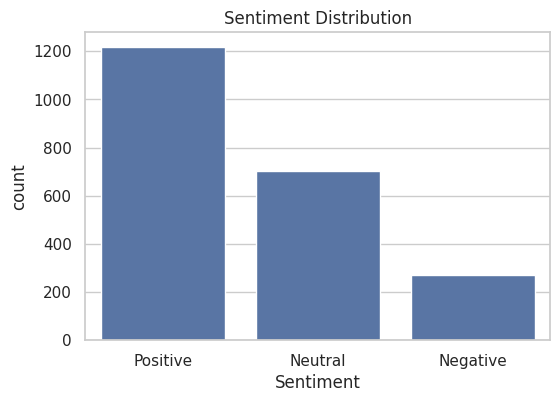

In [26]:
#Sentiment Distrubution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Distribution")
plt.show()

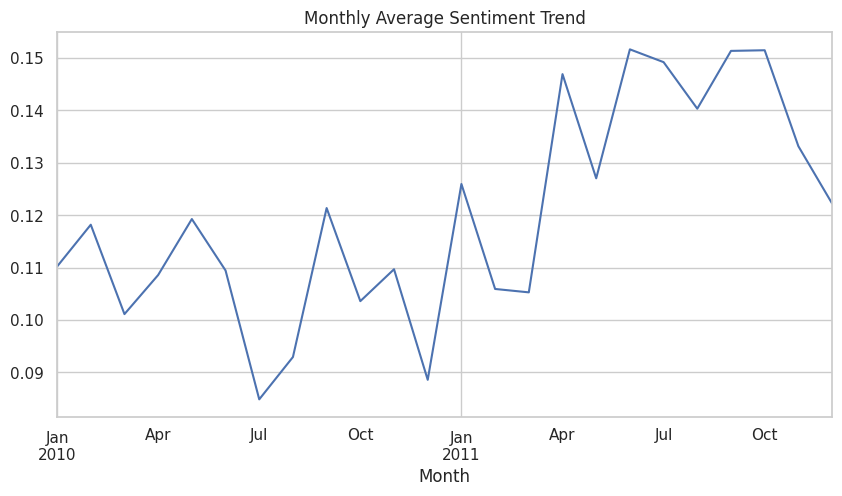

In [27]:
#Monthly Sentiment Trend
monthly_sentiment = df.groupby('Month')['Polarity'].mean()

plt.figure(figsize=(10,5))
monthly_sentiment.plot()
plt.title("Monthly Average Sentiment Trend")
plt.show()


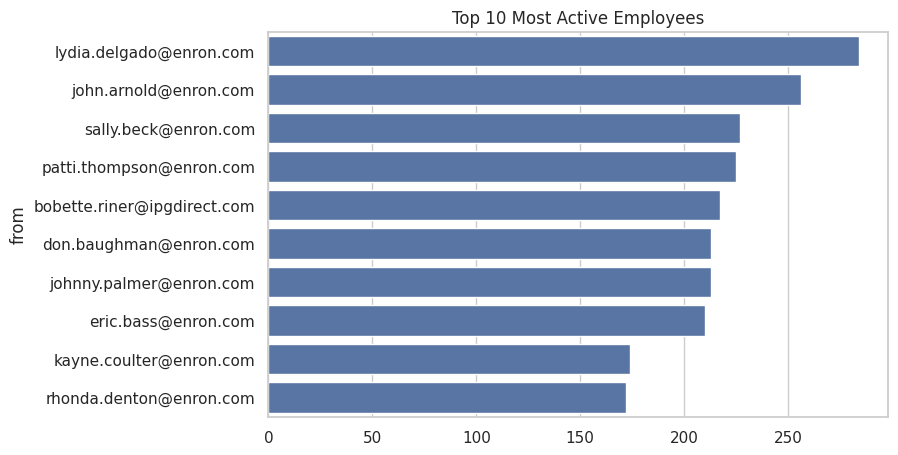

In [29]:
#Email frequency per employee
email_count = df['from'].value_counts().head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=email_count.values, y=email_count.index)
plt.title("Top 10 Most Active Employees")
plt.show()


#Task 3 - Employee Score Calculation

### Scoring Method

Each message receives:
- +1 for Positive
- -1 for Negative
- 0 for Neutral

Scores are aggregated monthly and reset every month.


In [30]:
score_map = {"Positive":1, "Negative":-1, "Neutral":0}
df['Score'] = df['Sentiment'].map(score_map)

employee_monthly_score = df.groupby(['from','Month'])['Score'].sum().reset_index()
employee_monthly_score.head()


,from,Month,Score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,8
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


#Task 4 - Employee Ranking

In [31]:
#Top 3 Positive Employees per Month
top_positive = (
    employee_monthly_score
    .sort_values(by=['Month','Score','from'], ascending=[True, False, True])
    .groupby('Month')
    .head(3)
)
top_positive

,from,Month,Score
120,kayne.coulter@enron.com,2010-01,9
24,don.baughman@enron.com,2010-01,5
48,eric.bass@enron.com,2010-01,5
73,john.arnold@enron.com,2010-02,10
1,bobette.riner@ipgdirect.com,2010-02,8
...,...,...,...
22,bobette.riner@ipgdirect.com,2011-11,8
142,kayne.coulter@enron.com,2011-11,7
167,lydia.delgado@enron.com,2011-12,6
191,patti.thompson@enron.com,2011-12,6


In [32]:
#Top 3 Negative Employees per Month
top_negative = (
    employee_monthly_score
    .sort_values(by=['Month','Score','from'], ascending=[True, True, True])
    .groupby('Month')
    .head(3)
)
top_negative


,from,Month,Score
192,rhonda.denton@enron.com,2010-01,0
0,bobette.riner@ipgdirect.com,2010-01,2
96,johnny.palmer@enron.com,2010-01,2
217,sally.beck@enron.com,2010-02,0
145,lydia.delgado@enron.com,2010-02,1
...,...,...,...
214,rhonda.denton@enron.com,2011-11,1
46,don.baughman@enron.com,2011-11,2
23,bobette.riner@ipgdirect.com,2011-12,0
119,johnny.palmer@enron.com,2011-12,2


#Task 5 - Flight Risk Identification

In [33]:
negative_count = df[df['Sentiment'] == 'Negative'] \
    .groupby(['from','Month']) \
    .size() \
    .reset_index(name='Negative_Count')

flight_risk = negative_count[negative_count['Negative_Count'] >= 4]

flight_risk


,from,Month,Negative_Count
5,bobette.riner@ipgdirect.com,2010-11,5
17,don.baughman@enron.com,2010-05,4
32,eric.bass@enron.com,2010-09,4
45,john.arnold@enron.com,2010-06,5
59,johnny.palmer@enron.com,2010-02,4
100,lydia.delgado@enron.com,2011-05,5
102,lydia.delgado@enron.com,2011-12,4
109,patti.thompson@enron.com,2011-03,4
121,rhonda.denton@enron.com,2010-08,4
123,rhonda.denton@enron.com,2010-12,4


In [34]:
#Extract Unique Employees
flight_risk_employees = flight_risk['from'].unique()
flight_risk_employees

array(['bobette.riner@ipgdirect.com', 'don.baughman@enron.com',
       'eric.bass@enron.com', 'john.arnold@enron.com',
       'johnny.palmer@enron.com', 'lydia.delgado@enron.com',
       'patti.thompson@enron.com', 'rhonda.denton@enron.com',
       'sally.beck@enron.com'], dtype=object)

#Task 6 - Predictive Modeling

In [35]:
#Feature Engineering
df['Message_Length'] = df['body'].apply(lambda x: len(str(x)))
df['Word_Count'] = df['body'].apply(lambda x: len(str(x).split()))

In [36]:
#Aggregate Monthly features
features = df.groupby(['from','Month']).agg({
    'Score':'sum',
    'Message_Length':'mean',
    'Word_Count':'mean'
}).reset_index()

In [37]:
#Model Training
X = features[['Message_Length','Word_Count']]
y = features['Score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test,y_pred))
print("R2 Score:", r2_score(y_test,y_pred))

MSE: 10.515503744020322
R2 Score: -0.1559027016327681


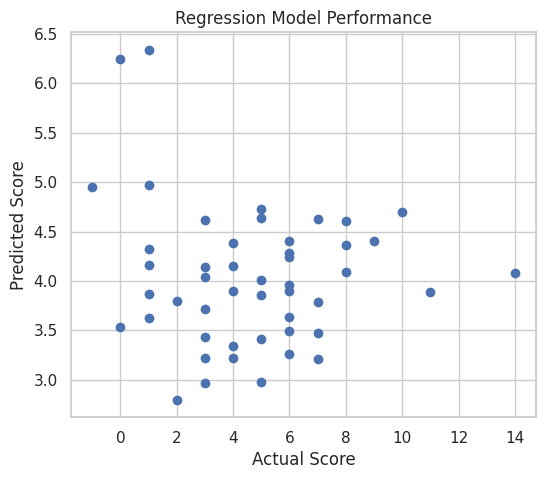

In [38]:
#Visualization
plt.figure(figsize=(6,5))
plt.scatter(y_test,y_pred)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Regression Model Performance")
plt.show()

#CONCLUSION
## Key Findings

- Sentiment is predominantly Neutral.
- Certain employees show consistently negative monthly scores.
- Flight risk employees identified based on ≥4 negative emails per month.
- Regression model shows moderate predictive capability.
- Message length and word count influence sentiment score trends.

## Recommendations

- Monitor employees flagged as flight risks.
- Investigate recurring negative months.
- Use predictive modeling to detect early sentiment decline.
